# Current effects on stress based on Jeffreys wind input and JONSWAP spectra

In [1]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc('font', size=12)

import numpy as np
from stress_current_interactions.diagnostics import phase_speed, form_drag
from stress_current_interactions.dispersion import wavenumber
from stress_current_interactions.source_functions import wind_input
from stress_current_interactions.spectral_shapes import jonswap, wavenumber_spectrum

## Fixed parameters

In [2]:
water_depth = 1e3 # m
rhow = 1e3 # water density [kg/m^3]
grav_accel = 9.8 # m/s^2

## Frequency, wavenumber, and phase speed

In [3]:
f = np.logspace(-1, 1, 100) # frequency range from 0.1 to 10 Hz
k = wavenumber(f, water_depth)
Cp = phase_speed(f, k)

## Example wave spectra

Let's look at JONSWAP frequency spectra for 3 wind speeds (5, 10, 15 m/s) and 3 fetches (1, 10, 100 km).

$$
S_{\eta\eta}(\omega) = \dfrac{\alpha g^2}{\omega^5} \exp \left[ - \dfrac{5}{4} \left( \dfrac{\omega_p}{\omega} \right)^4 \right] \gamma^r
$$
,
$$
r = \exp \left[ - \dfrac{\left( \omega - \omega_p \right)^2}{2 \sigma^2 \omega_p^2}  \right]
$$
, 
$$
\alpha = 0.076 \left( \dfrac{U_{10}^2}{x g} \right)^{0.22}
$$
,
$$
\omega_p = 22 \left( \dfrac{g^2}{U_{10} x} \right)^{1/3}
$$


where:

* $S_{\eta\eta}$ is the frequency wave spectrum
* $\omega$ is the angular frequency
* $x$ is the fetch (m)
* $U_{10}$ is the 10-m wind speed (m/s)
* $g$ is the gravitational acceleration (m/s$^2$)

JONSWAP is nice because it's:

* Simple to understand and calculate--only 2 input parameters (wind speed and fetch)
* Based on field data, so it's representative of real ocean waves

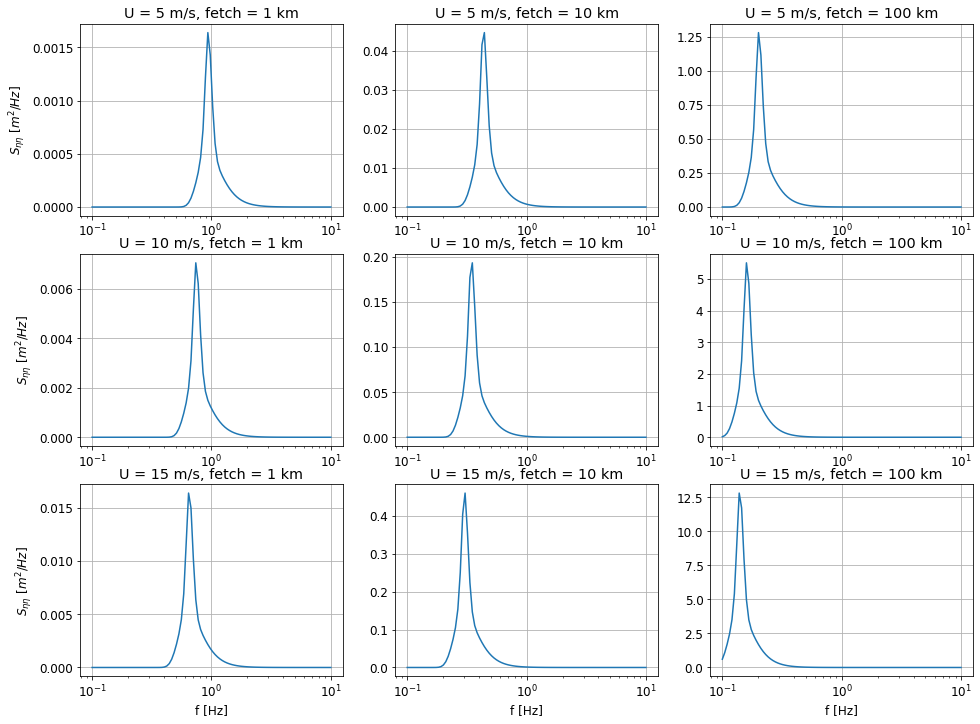

In [4]:
fig = plt.figure(figsize=(16, 12))
for n, wspd in enumerate([5, 10, 15]):
    for m, fetch in enumerate([1e3, 1e4, 1e5]):
        ax = plt.subplot2grid((3, 3), (n, m))
        ax.set_title('U = %i m/s' % wspd + ', fetch = %i km' % (fetch // 1000))
        ax.semilogx(f, jonswap(f, wspd, fetch))
        #ax.set_ylim(1e-5, 1e2)
        ax.grid()
        if n == 2: ax.set_xlabel('f [Hz]')
        if m == 0: ax.set_ylabel(r'$S_{\eta\eta}$ [$m^2/Hz$]')

## Given these spectra and some wind, what is wind input like?

$$
S_{in} = \mathcal{A} \dfrac{\rho_a}{\rho_w} \left( U_z - c_p \right) \left| U_z - c_p \right| \dfrac{\omega k}{g} F\left(k\right)
$$

where:

* $\mathcal{A}$ is the sheltering coefficient (assume constant)
* $\rho_a$ and $\rho_w$ are air and water density, respectively
* $U_z$ is the wind speed at _some_ height (don't worry about wind height for now)
* $c_p$ is the phase speed
* $F(k)$ is the wavenumber spectrum

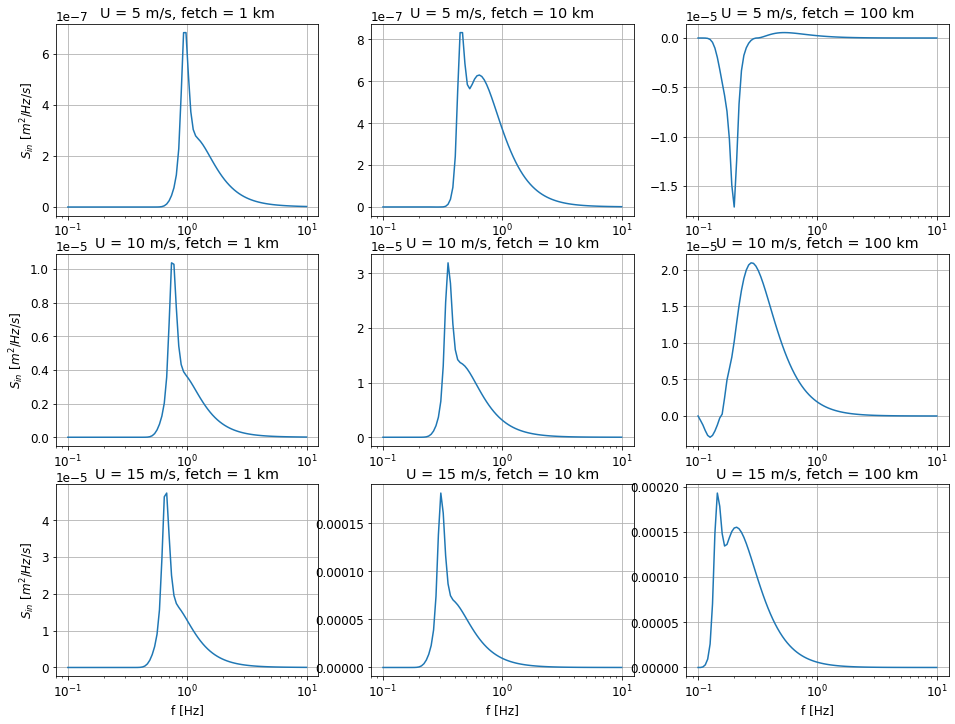

In [5]:
fig = plt.figure(figsize=(16, 12))
for n, wspd in enumerate([5, 10, 15]):
    for m, fetch in enumerate([1e3, 1e4, 1e5]):
        ax = plt.subplot2grid((3, 3), (n, m))
        ax.set_title('U = %i m/s' % wspd + ', fetch = %i km' % (fetch // 1000))
        F = jonswap(f, wspd, fetch)
        Fk = wavenumber_spectrum(f, F, water_depth)
        Sin = wind_input(wspd, f, k, Cp, current=0)
        ax.semilogx(f, Sin * Fk)
        ax.grid()
        if n == 2: ax.set_xlabel('f [Hz]')
        if m == 0: ax.set_ylabel(r'$S_{in}$ [$m^2/Hz/s$]')

## What if we consider currents?

Now each wave is Doppler-shifted by the current:

$$
S_{in} = \mathcal{A} \dfrac{\rho_a}{\rho_w} \left( U_z - c_p - u\right) \left| U_z - c_p -u\right| \dfrac{\omega k}{g} F\left(k\right)
$$

For simplicity, this current is depth-uniform and all waves are equally affected by it.

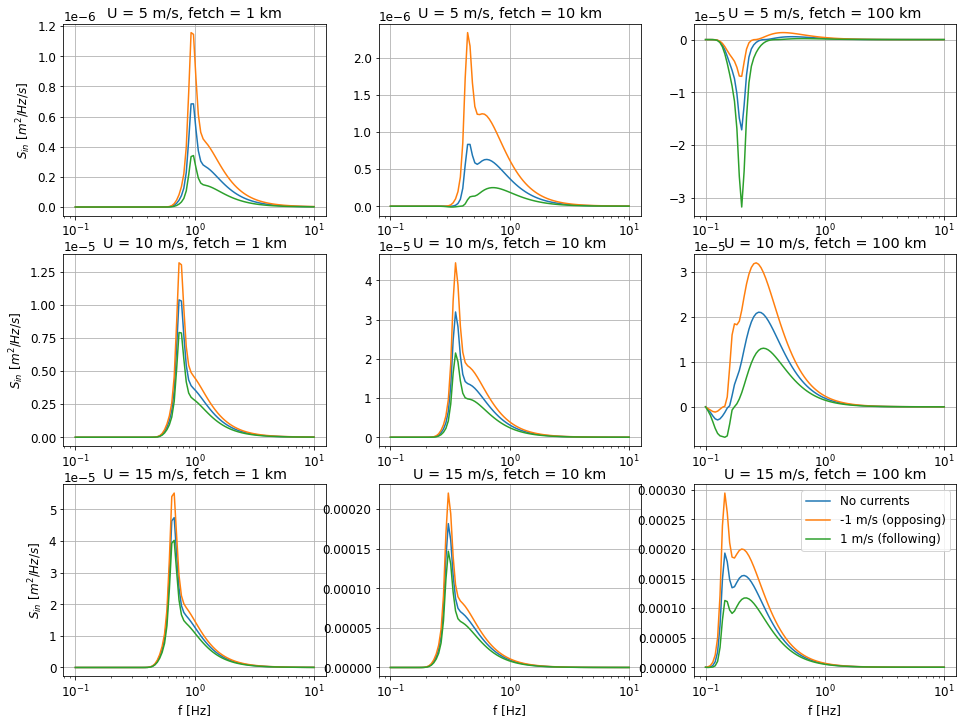

In [6]:
colors = ['tab:blue', 'tab:orange', 'tab:green']
labels = ['No currents', '-1 m/s (opposing)', '1 m/s (following)']
fig = plt.figure(figsize=(16, 12))
for n, wspd in enumerate([5, 10, 15]):
    for m, fetch in enumerate([1e3, 1e4, 1e5]):
        ax = plt.subplot2grid((3, 3), (n, m))
        ax.set_title('U = %i m/s' % wspd + ', fetch = %i km' % (fetch // 1000))
        F = jonswap(f, wspd, fetch)
        Fk = wavenumber_spectrum(f, F, water_depth)
        for ncol, current in enumerate([0, -1, 1]):
            Sin = wind_input(wspd, f, k, Cp, current=current)
            ax.semilogx(f, Sin * Fk, label=labels[ncol])
        ax.grid()
        if n == 2: ax.set_xlabel('f [Hz]')
        if m == 0: ax.set_ylabel(r'$S_{in}$ [$m^2/Hz/s$]')
        if n == 2 and m == 2: plt.legend(loc='upper right')

## How about the stress distribution?

Given wind input function and a wave spectrum, we can calculate the form drag:

$$
\tau = \rho_w g \int \dfrac{S_{in}}{c_p} F(k) dk
$$

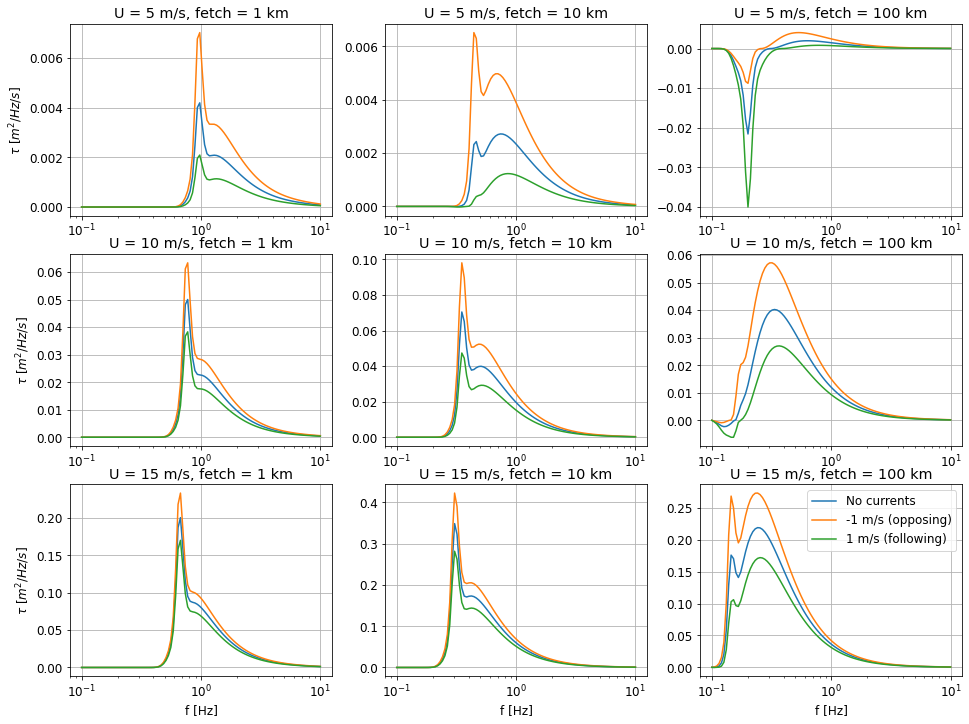

In [7]:
colors = ['tab:blue', 'tab:orange', 'tab:green']
labels = ['No currents', '-1 m/s (opposing)', '1 m/s (following)']
fig = plt.figure(figsize=(16, 12))
for n, wspd in enumerate([5, 10, 15]):
    for m, fetch in enumerate([1e3, 1e4, 1e5]):
        ax = plt.subplot2grid((3, 3), (n, m))
        ax.set_title('U = %i m/s' % wspd + ', fetch = %i km' % (fetch // 1000))
        F = jonswap(f, wspd, fetch)
        Fk = wavenumber_spectrum(f, F, water_depth)
        for ncol, current in enumerate([0, -1, 1]):
            Sin = wind_input(wspd, f, k, Cp, current=current)
            tau = rhow * grav_accel * Sin / Cp * Fk
            ax.semilogx(f, tau, label=labels[ncol])
        ax.grid()
        if n == 2: ax.set_xlabel('f [Hz]')
        if m == 0: ax.set_ylabel(r'$\tau$ [$m^2/Hz/s$]')
        if n == 2 and m == 2: plt.legend(loc='upper right')

## Stress change due to currents relative to no currents

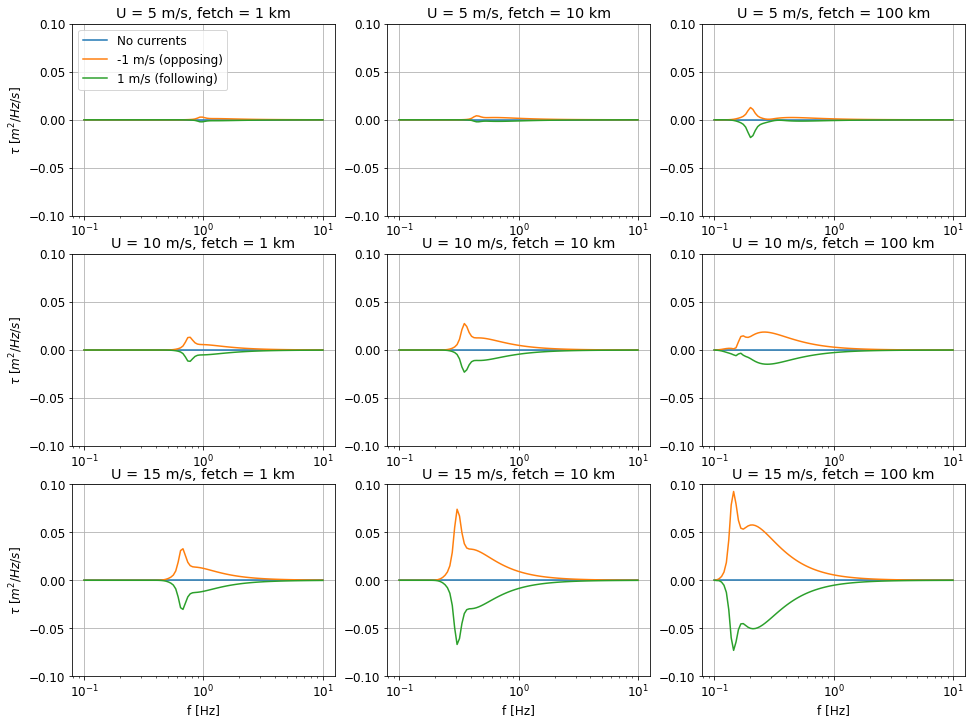

In [8]:
colors = ['tab:blue', 'tab:orange', 'tab:green']
labels = ['No currents', '-1 m/s (opposing)', '1 m/s (following)']
fig = plt.figure(figsize=(16, 12))
for n, wspd in enumerate([5, 10, 15]):
    for m, fetch in enumerate([1e3, 1e4, 1e5]):
        ax = plt.subplot2grid((3, 3), (n, m))
        ax.set_title('U = %i m/s' % wspd + ', fetch = %i km' % (fetch // 1000))
        F = jonswap(f, wspd, fetch)
        Fk = wavenumber_spectrum(f, F, water_depth)
        Sin = wind_input(wspd, f, k, Cp, current=0)
        tau0 = rhow * grav_accel * Sin / Cp * Fk
        for ncol, current in enumerate([0, -1, 1]):
            Sin = wind_input(wspd, f, k, Cp, current=current)
            tau = rhow * grav_accel * Sin / Cp * Fk
            ax.semilogx(f, tau - tau0, label=labels[ncol])
        ax.grid()
        ax.set_ylim(-0.1, 0.1)
        if n == 2: ax.set_xlabel('f [Hz]')
        if m == 0: ax.set_ylabel(r'$\tau$ [$m^2/Hz/s$]')
        if n == 0 and m == 0: plt.legend(loc='upper left')

## Form drag as function of wind speed, fetch, and current

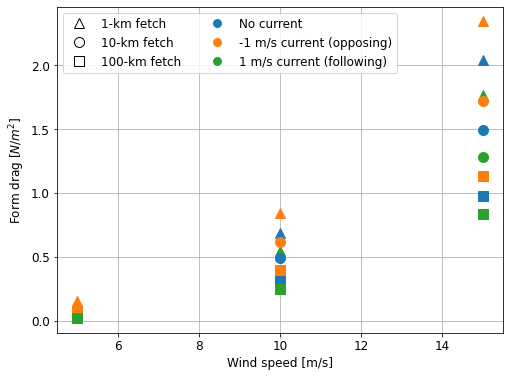

In [9]:
colors = ['tab:blue', 'tab:orange', 'tab:green']
markers = ['^', 'o', 's']
fig = plt.figure(figsize=(8, 6))
for n, wspd in enumerate([5, 10, 15]):
    for m, fetch in enumerate([1e3, 1e4, 1e5]):
        F = jonswap(f, wspd, fetch)
        Fk = wavenumber_spectrum(f, F, water_depth)
        for ncol, current in enumerate([0, -1, 1]):
            Sin = wind_input(wspd, f, k, Cp, current=current)
            tau = form_drag(Sin, Fk, Cp, k)
            plt.plot(wspd, tau, color=colors[ncol], marker=markers[m], ms=10)
plt.grid()
plt.xlabel('Wind speed [m/s]')
plt.ylabel('Form drag [$N/m^2$]')
plt.plot(np.nan, np.nan, linestyle='', mfc='w', mec='k', marker='^', ms=10, label='1-km fetch')
plt.plot(np.nan, np.nan, linestyle='', mfc='w', mec='k', marker='o', ms=10, label='10-km fetch')
plt.plot(np.nan, np.nan, linestyle='', mfc='w', mec='k', marker='s', ms=10, label='100-km fetch')
plt.plot(np.nan, np.nan, linestyle='', mfc='tab:blue', mec='w', marker='o', ms=10, label='No current')
plt.plot(np.nan, np.nan, linestyle='', mfc='tab:orange', mec='w', marker='o', ms=10, label='-1 m/s current (opposing)')
plt.plot(np.nan, np.nan, linestyle='', mfc='tab:green', mec='w', marker='o', ms=10, label='1 m/s current (following)')
plt.legend(ncol=2)